# Constructing dataset of fire incidences and their environmental predictors

Author: Jatan Buch (v1, 231120) 


In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
from scipy import stats, interpolate
from scipy.optimize import minimize
from scipy.special import gamma
from sklearn.linear_model import LinearRegression
from math import factorial
import itertools

import netCDF4 # module that reads in .nc files (built on top of HDF5 format)
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import xarray
import rioxarray
import xesmf as xe # for regridding
import pickle # for saving and loading models
from pathlib import Path

# CDS API
import cdsapi

# To map GRIB files to NetCDF Common Data Model
import cfgrib

# self-libraries
from data_utils import *

from shapely.geometry import Point, mapping, LineString
from shapely.geometry.polygon import Polygon
from pyproj import CRS, Transformer # for transforming projected coordinates to elliptical coordinates
import cartopy.crs as ccrs # for defining and transforming coordinate systems
import cartopy.feature as cfeature # to add features to a cartopy map
import cartopy.io.shapereader as shpreader
from shapely.geometry import Point, mapping
from shapely.geometry.polygon import Polygon
from pyproj import CRS, Transformer # for transforming projected coordinates to elliptical coordinates

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from calendar import monthrange
from cftime import num2date, date2num, DatetimeGregorian
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import matplotlib.path as mpltPath
from plot_params_mpl39 import params
import matplotlib.pylab as pylab
import seaborn as sns
pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

In [2]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "Helvetica"
})

sub = (51.6, -128, 26.5, -101) # North/West/South/East
ds_out = xarray.Dataset(
    {
        "lat": (["lat"], np.arange(26.5, 51.6, 0.125), {"units": "degrees_north"}),
        "lon": (["lon"], np.arange(-128, -101, 0.125), {"units": "degrees_west"}),
    }
)

## Vegetation data

In [3]:
casm_ds= xarray.open_dataset('../data/vegetation/casm_for_jatan.nc') #, chunks={"date": 10}

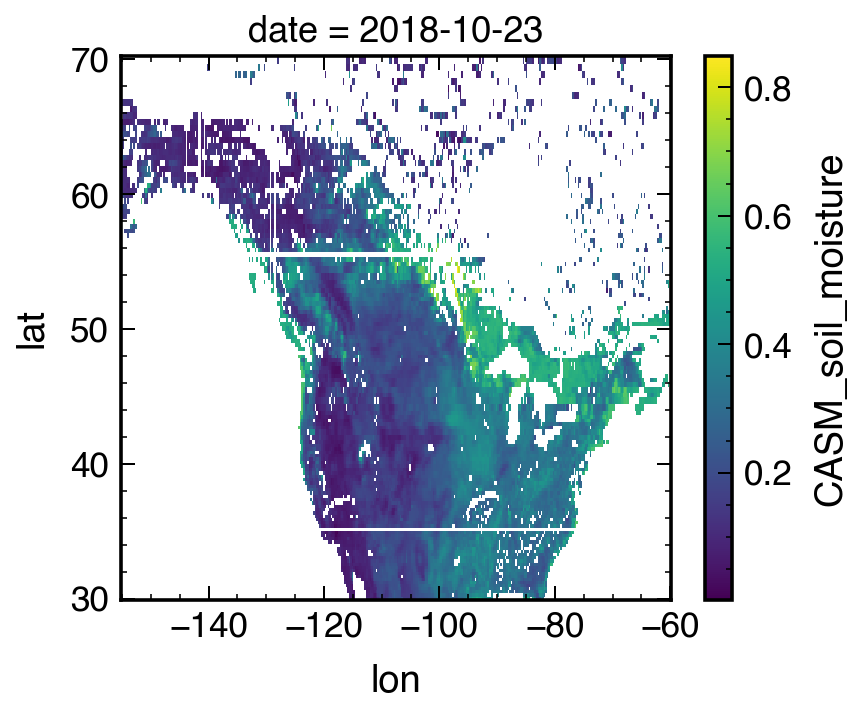

In [71]:
casm_ds.CASM_soil_moisture[1983].plot()

In [4]:
casm_ds_conus_XY= regridding_func(casm_ds, subarea= sub, dsout= ds_out, regrid_scheme= 'bilinear')
#casm_ds_conus_XY.to_netcdf('../data/12km/casm_conus_12km.nc')

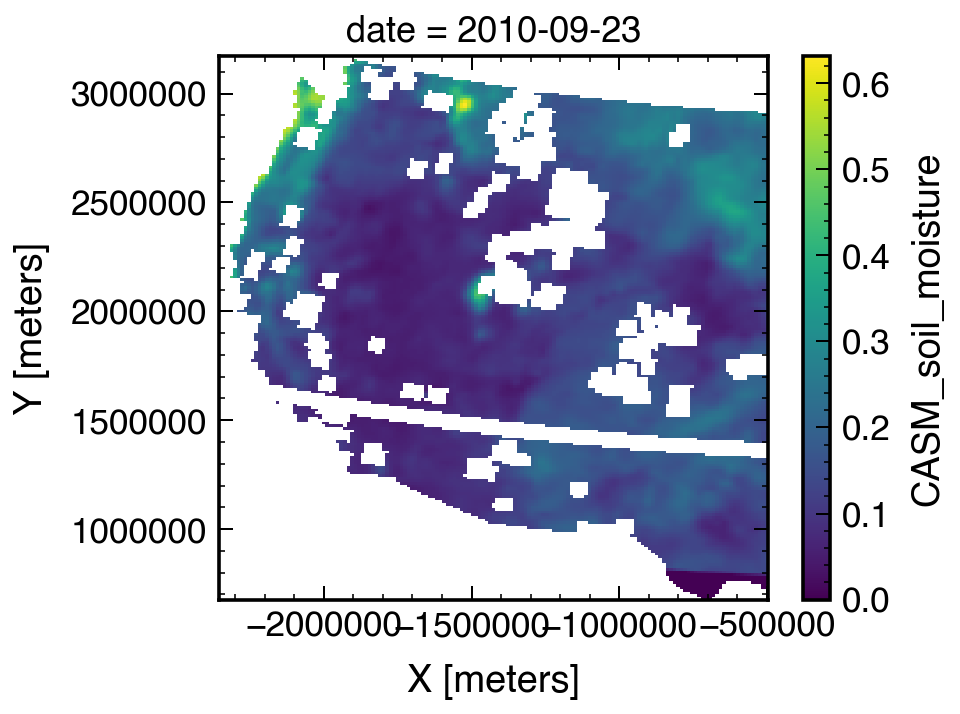

In [5]:
casm_ds_conus_XY.CASM_soil_moisture[1000].plot()

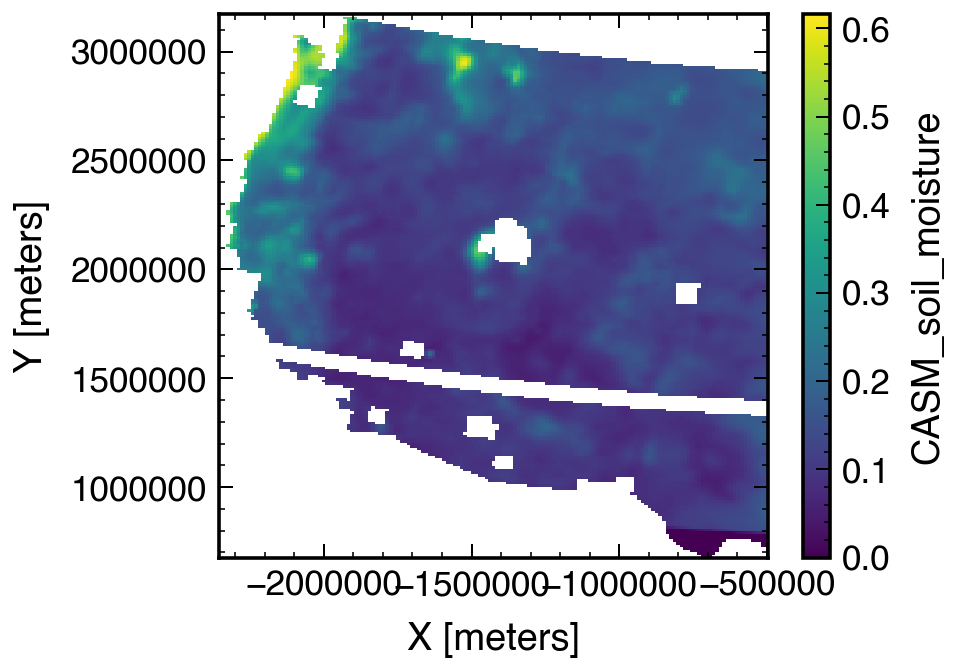

In [64]:
casm_ds_conus_XY.CASM_soil_moisture.mean(dim= 'date').plot()

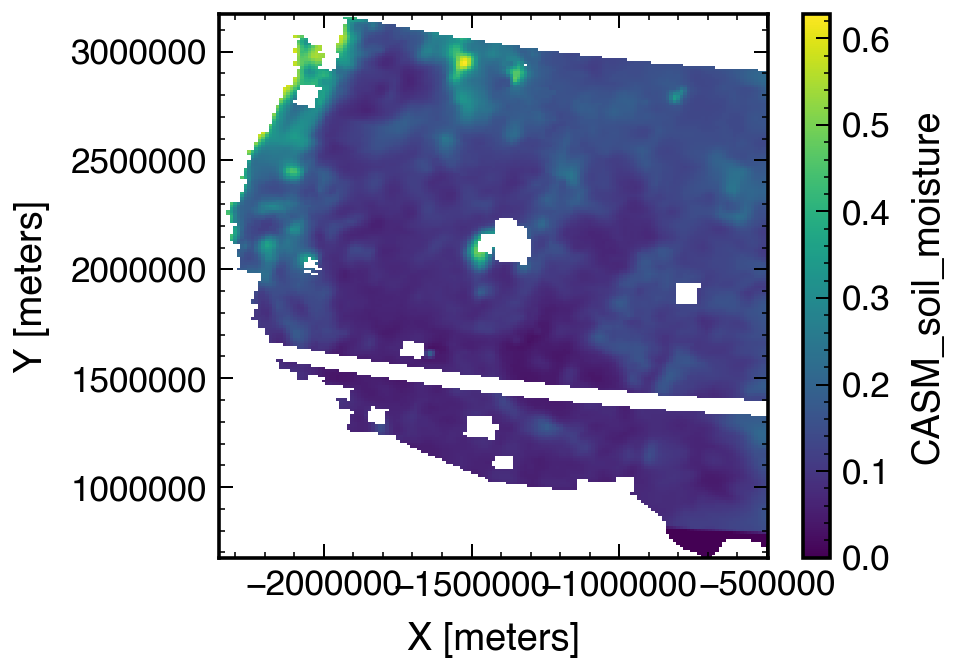

In [67]:
casm_ds_conus_XY.CASM_soil_moisture.sel(date= casm_ds_conus_XY.date.dt.month == 6).mean(dim= 'date').plot()

In [7]:
csif_ds= xarray.open_dataset('../data/vegetation/csif_for_jatan.nc')

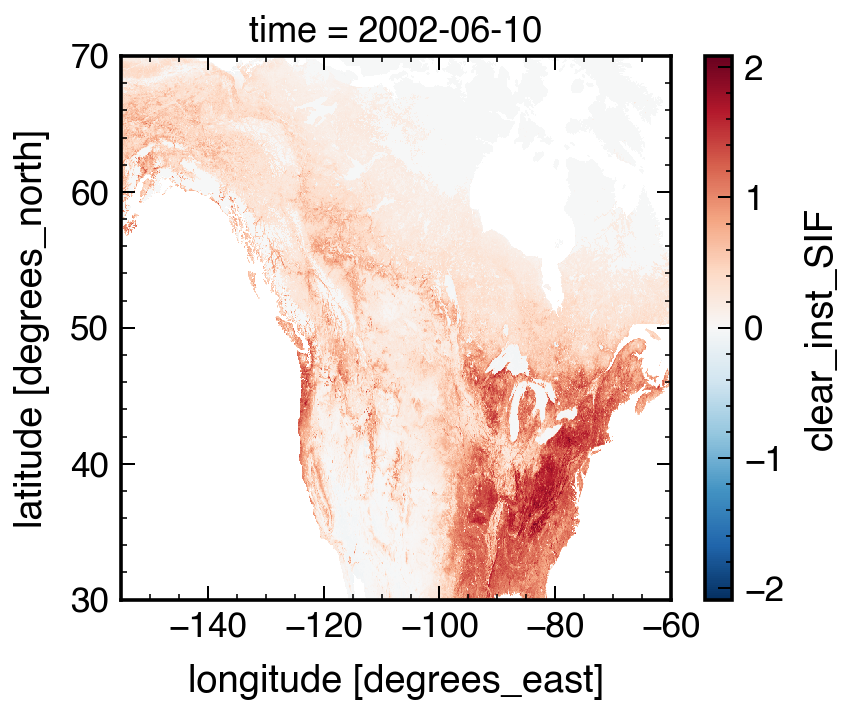

In [9]:
csif_ds.clear_inst_SIF[40].plot()

In [10]:
csif_ds_conus_XY= regridding_func(csif_ds.clear_inst_SIF, subarea= sub, dsout= ds_out, regrid_scheme= 'bilinear')
#csif_ds_conus_XY.to_netcdf(''../data/12km/csif_clear_inst_conus_12km.nc')

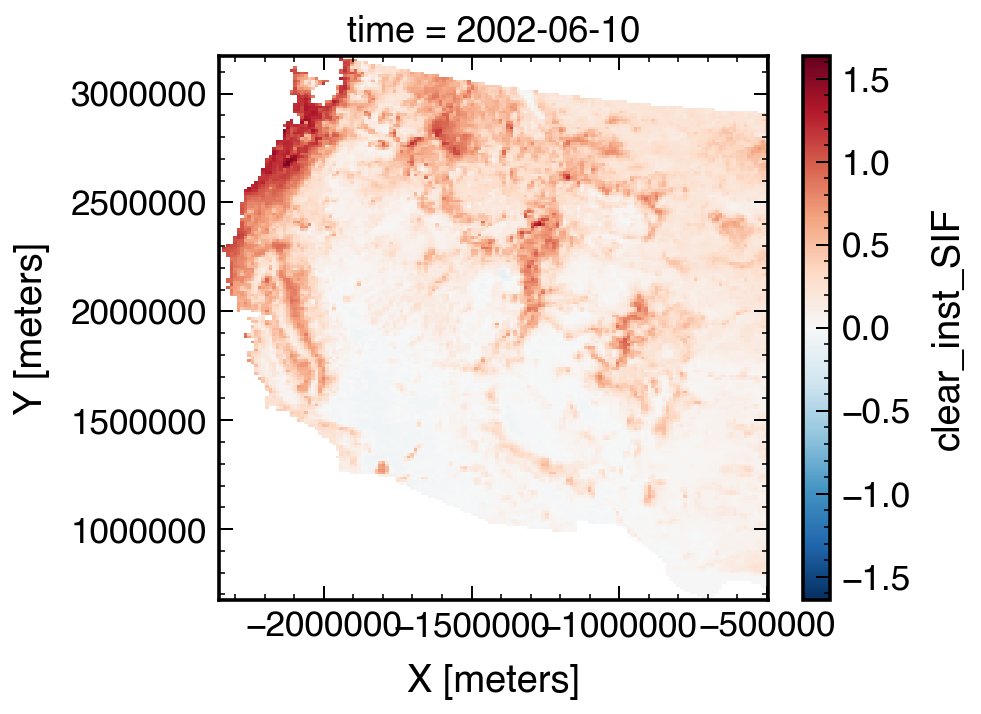

In [11]:
csif_ds_conus_XY[40].plot()

## ERA5 reanalysis data

(Used instead of gridMET for future compatability with Canadian/Australian data as well)

In [3]:
DATADIR = '../data/meteorology'
var_arr= ['2m_dewpoint_temperature', '2m_temperature', 'total_precipitation'] #'10m_u_component_of_wind', '10m_v_component_of_wind',
yr_arr= list(np.arange(2002, 2021).astype(str))

### Hourly data

In [ ]:
URL = 'https://cds.climate.copernicus.eu/api/v2'
KEY = '136899:e611201e-7672-4596-9783-4fc89f7161e3'

In [19]:
c = cdsapi.Client(url=URL, key=KEY)
for var in var_arr:
    for yr in yr_arr:
        c.retrieve(
            'reanalysis-era5-single-levels',
            {
                'product_type': 'reanalysis',
                'format': 'grib',
                'variable': [var],
                'year': [yr],
                'month': ['02', '03', '04', '05', '06', '07', '08', '09'],
                'day': [
                    '01', '02', '03',
                    '04', '05', '06',
                    '07', '08', '09',
                    '10', '11', '12',
                    '13', '14', '15',
                    '16', '17', '18',
                    '19', '20', '21',
                    '22', '23', '24',
                    '25', '26', '27',
                    '28', '29', '30',
                    '31',
                ],
                'time': [
                    '00:00', '01:00', '02:00',
                    '03:00', '04:00', '05:00',
                    '06:00', '07:00', '08:00',
                    '09:00', '10:00', '11:00',
                    '12:00', '13:00', '14:00',
                    '15:00', '16:00', '17:00',
                    '18:00', '19:00', '20:00',
                    '21:00', '22:00', '23:00',
                ],
                'area': [51.6, -128, 26.5, -101],
            },
            f'{DATADIR}hourly/era5_wus_forecast_hourly_%s'%var + f'_%s.grib'%yr)

2023-11-21 09:23:23,456 INFO Welcome to the CDS
2023-11-21 09:23:23,457 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-11-21 09:23:23,684 INFO Request is queued
2023-11-21 09:27:43,015 INFO Request is running
2023-11-21 09:31:43,950 INFO Request is completed
2023-11-21 09:31:43,952 INFO Downloading https://download-0020.copernicus-climate.eu/cache-compute-0020/cache/data6/adaptor.mars.internal-1700576850.5966997-16543-1-dd2a740b-7b32-411b-a01c-670f7963d64e.grib to ../data/meteorology//era5_wus_forecast_hourly_2m_dewpoint_temperature_2020.grib (123.5M)
2023-11-21 09:32:01,091 INFO Download rate 7.2M/s  
2023-11-21 09:32:01,315 INFO Welcome to the CDS
2023-11-21 09:32:01,317 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-11-21 09:32:01,448 INFO Request is queued
2023-11-21 09:36:20,931 INFO Request is running
2023-11-21 09:38:21,409 INFO Request is completed
2023-

In [20]:
ds= xarray.open_dataset(f'{DATADIR}hourly/era5_wus_forecast_hourly_2m_temperature_2002.grib', engine='cfgrib')

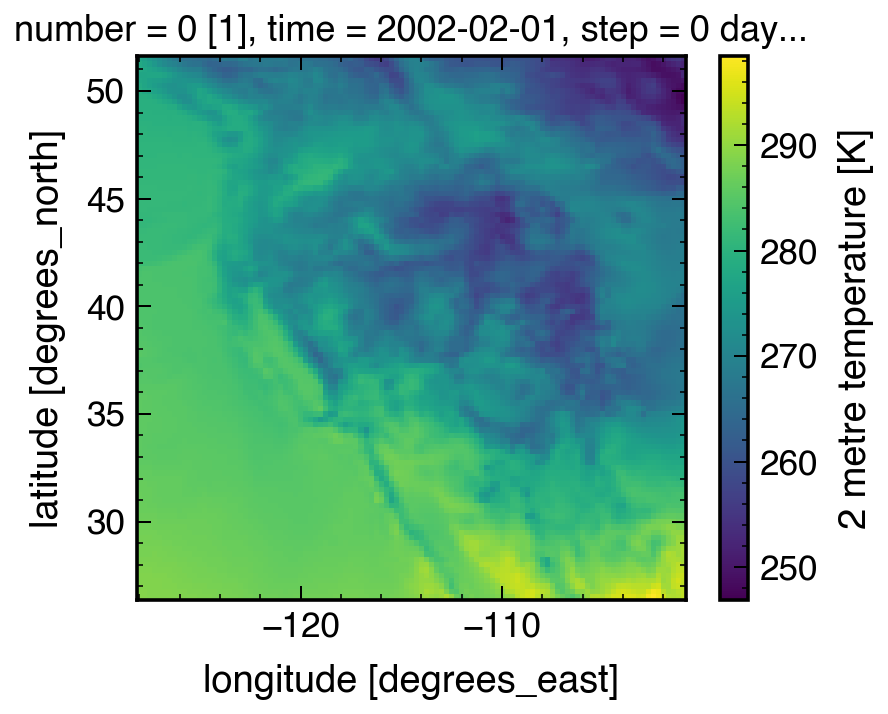

In [27]:
ds.t2m[0].plot()

### Daily data

In [93]:
load_daily_meteorlogical_predictors(var= '2m_dewpoint_temperature', yrarr= yr_arr, datadir= DATADIR)

100%|██████████| 19/19 [01:21<00:00,  4.26s/it]


In [175]:
load_daily_meteorlogical_predictors(var= 'total_precipitation', yrarr= yr_arr, datadir= DATADIR)

100%|██████████| 19/19 [00:55<00:00,  2.90s/it]


### Regridded data

In [5]:
tmax_ds= xarray.open_dataarray(f'{DATADIR}/daily/era5_wus_forecast_daily_Tmax_2002-2020.nc')
tmax_ds_conus_XY= regridding_func(tmax_ds, subarea= sub, dsout= ds_out, regrid_scheme= 'bilinear', latname= 'latitude', lonname= 'longitude')
tmax_ds_conus_XY= tmax_ds_conus_XY.drop(['number', 'step', 'surface'])
tmax_ds_conus_XY.to_netcdf('../data/12km/Tmax_daily_conus_2002-2020_12km.nc')

prec_ds= xarray.open_dataarray(f'{DATADIR}/daily/era5_wus_forecast_daily_Prec_2002-2020.nc')
prec_ds_conus_XY= regridding_func(prec_ds, subarea= sub, dsout= ds_out, regrid_scheme= 'bilinear', latname= 'latitude', lonname= 'longitude')
prec_ds_conus_XY= prec_ds_conus_XY.drop(['number', 'surface'])
prec_ds_conus_XY.to_netcdf('../data/12km/Prec_daily_conus_2002-2020_12km.nc')

vpd_ds= xarray.open_dataarray(f'{DATADIR}/daily/era5_wus_forecast_daily_VPD_2002-2020.nc')
vpd_ds_conus_XY= regridding_func(vpd_ds, subarea= sub, dsout= ds_out, regrid_scheme= 'bilinear', latname= 'latitude', lonname= 'longitude')
vpd_ds_conus_XY= vpd_ds_conus_XY.drop(['number', 'step', 'surface'])
vpd_ds_conus_XY.to_netcdf('../data/12km/VPD_daily_conus_2002-2020_12km.nc')

## Fire perimeters

In [6]:
# Although both gpkg and shapefiles are provided, we will use the gpkg files as they contain all the information in one place

eventsdf= gpd.read_file('../data/fire/fired_conus-ak_nov2001-march2021/fired_conus-ak_daily_nov2001-march2021.gpkg')

In [43]:
eventsdf

,did,id,date,ig_date,ig_day,ig_month,ig_year,last_date,event_day,event_dur,...,lc_mode,lc_name,lc_desc,lc_type,eco_mode,eco_type,eco_name,ig_utm_x,ig_utm_y,geometry
0,1-2000-11-02,1,2000-11-02,2000-11-02,307,11,2000,2000-11-04,1,3,...,4.0,Deciduous Broadleaf Forests,Dominated by deciduous broadleaf trees (canopy...,IGBP global vegetation classification scheme,8.4.2,Level III Ecoregions (NA-Commission for Enviro...,Central Appalachians,-7.431536e+06,4.123483e+06,"MULTIPOLYGON (((-7431768.629 4123250.521, -743..."
1,1-2000-11-04,1,2000-11-04,2000-11-02,307,11,2000,2000-11-04,3,3,...,4.0,Deciduous Broadleaf Forests,Dominated by deciduous broadleaf trees (canopy...,IGBP global vegetation classification scheme,8.4.2,Level III Ecoregions (NA-Commission for Enviro...,Central Appalachians,-7.431536e+06,4.123483e+06,"MULTIPOLYGON (((-7431303.317 4124177.146, -743..."
2,10-2000-11-02,10,2000-11-02,2000-11-02,307,11,2000,2000-11-05,1,4,...,12.0,Croplands,At least 60% of area is cultivated cropland,IGBP global vegetation classification scheme,9.4.1,Level III Ecoregions (NA-Commission for Enviro...,High Plains,-8.859002e+06,4.191590e+06,"MULTIPOLYGON (((-8859233.109 4191357.490, -885..."
3,10-2000-11-05,10,2000-11-05,2000-11-02,307,11,2000,2000-11-05,4,4,...,12.0,Croplands,At least 60% of area is cultivated cropland,IGBP global vegetation classification scheme,9.4.1,Level III Ecoregions (NA-Commission for Enviro...,High Plains,-8.859002e+06,4.191590e+06,"MULTIPOLYGON (((-8859235.109 4190430.865, -885..."
4,100-2000-11-04,100,2000-11-04,2000-11-04,309,11,2000,2000-11-04,1,1,...,9.0,Savannas,Tree cover 10-30% (canopy>2m),IGBP global vegetation classification scheme,8.5.3,Level III Ecoregions (NA-Commission for Enviro...,Southern Coastal Plain,-7.952299e+06,2.985587e+06,"MULTIPOLYGON (((-7952532.123 2985354.489, -795..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627028,99992-2005-07-13,99992,2005-07-13,2005-07-13,194,7,2005,2005-07-13,1,1,...,12.0,Croplands,At least 60% of area is cultivated cropland,IGBP global vegetation classification scheme,9.4.2,Level III Ecoregions (NA-Commission for Enviro...,Central Great Plains,-8.655608e+06,4.123946e+06,"MULTIPOLYGON (((-8655840.827 4123713.833, -865..."
627029,99995-2005-07-13,99995,2005-07-13,2005-07-13,194,7,2005,2005-07-13,1,1,...,255.0,Unclassified,Has not received a map label because of missin...,IGBP global vegetation classification scheme,6.1.2,Level III Ecoregions (NA-Commission for Enviro...,Alaska Range,-7.205439e+06,7.027064e+06,"MULTIPOLYGON (((-7205672.024 7026831.315, -720..."
627030,99996-2005-07-13,99996,2005-07-13,2005-07-13,194,7,2005,2005-07-14,1,2,...,16.0,Barren,At least 60% of area is non-vegetated barren(s...,IGBP global vegetation classification scheme,10.1.3,Level III Ecoregions (NA-Commission for Enviro...,Northern Basin and Range,-9.743930e+06,4.710500e+06,"MULTIPOLYGON (((-9744162.398 4710267.733, -974..."
627031,99996-2005-07-14,99996,2005-07-14,2005-07-13,194,7,2005,2005-07-14,2,2,...,16.0,Barren,At least 60% of area is non-vegetated barren(s...,IGBP global vegetation classification scheme,10.1.3,Level III Ecoregions (NA-Commission for Enviro...,Northern Basin and Range,-9.743930e+06,4.710500e+06,"MULTIPOLYGON (((-9744625.710 4710267.733, -974..."


In [39]:
eventsdf[eventsdf.event_dur > 5].head()[['date', 'pixels', 'tot_pix', 'dy_ar_km2', 'tot_ar_km2', 'geometry']]

,date,pixels,tot_pix,dy_ar_km2,tot_ar_km2,geometry
9,2005-07-13,1,33,0.214659,7.083736,"MULTIPOLYGON (((-8073920.055 5297284.944, -807..."
10,2005-07-14,20,33,4.293173,7.083736,"MULTIPOLYGON (((-8075309.993 5295431.694, -807..."
11,2005-07-16,10,33,2.146587,7.083736,"MULTIPOLYGON (((-8075773.305 5294968.381, -807..."
12,2005-07-18,2,33,0.429317,7.083736,"MULTIPOLYGON (((-8074846.680 5294968.381, -807..."
14,2005-07-14,1,20,0.214659,4.293173,"MULTIPOLYGON (((-8515920.386 4250198.205, -851..."


<AxesSubplot:>

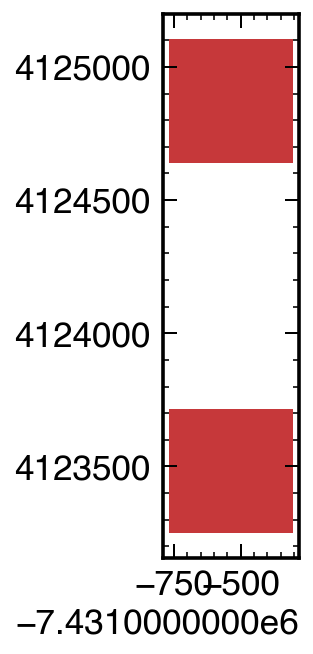

In [20]:
eventsdf.loc[[0]].geometry.plot()

<AxesSubplot:>

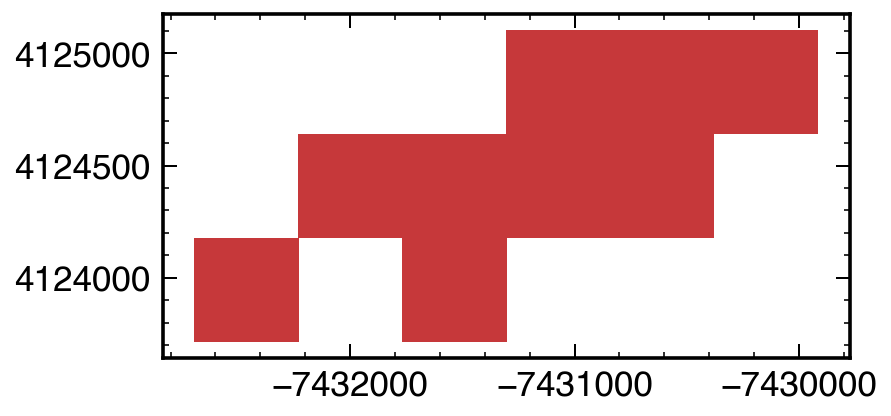

In [36]:
eventsdf.loc[[1]].geometry.plot()